# Demonstrating unexpected behaviour with increasing latent dimensions in autoencoder

I think I see strange behaviour with autoencoders on the ATAC-seq data (very sparse): increasing latent dimension does not improve performance.

Below is (hopefully) reproducible example of that

In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import optax
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import h5py
import hdf5plugin
import copy

from typing import Iterator, Mapping, Tuple, NamedTuple, Sequence, Union

Script parameters

In [2]:
batch_size = 128 # Size of the batch to train on, number of cells
learning_rate = 0.001 # Learning rate for the optimizer
training_steps = 201 # Number of training steps to run: in sequence, each step = batch size
eval_frequency = 10 # How often to evaluate the model on validation data
random_seed = 42 # Random seed
l1_coef = 0 # Weight for L1 loss

In [3]:
Batch = Mapping[str, np.ndarray]
HiddenSize = Union[int, tuple]

DEFAULT_OUTPUT_SHAPE: Sequence[int] = (28, 28, 1)

Autoencoder definition (flexible). This is based on the Jax library for fast computation + Haiku framework for writing neural networks using Jax.

For activation function I chose `leaky_relu`. I do not apply layer norm or batch norm (not sure if I should).

In [4]:
class Encoder(hk.Module):
    """Encoder model."""

    def __init__(self, hidden_size: HiddenSize = 512, latent_size: int = 10):
        super().__init__()
        if not isinstance(hidden_size, tuple):
            hidden_size = (hidden_size,)
        self._hidden_size = hidden_size
        self._latent_size = latent_size

    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """Returns latent layer and sum of all activations"""
        x = hk.Flatten()(x)
        activation_sum = 0
        for layer_size in self._hidden_size:
            x = hk.Linear(layer_size)(x)
            x = hk.RMSNorm(-1)(x)
            activation_sum += jnp.mean(jnp.abs(x))
            x = jax.nn.leaky_relu(x)

        return hk.Linear(self._latent_size)(x), activation_sum


class Decoder(hk.Module):
    """Decoder model."""
    
    def __init__(
        self,
        hidden_size: HiddenSize = 512,
        output_shape: Sequence[int] = DEFAULT_OUTPUT_SHAPE,
    ):
        super().__init__()
        if not isinstance(hidden_size, tuple):
            hidden_size = (hidden_size,)
        self._hidden_size = hidden_size
        self._output_shape = output_shape

    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
        """Returns reconstructed input and sum of all activations"""
        activation_sum = 0
        for layer_size in reversed(self._hidden_size):
            z = hk.Linear(layer_size)(z)
            z = hk.RMSNorm(-1)(z)
            activation_sum += jnp.mean(jnp.abs(z))
            z = jax.nn.leaky_relu(z)

        return hk.Linear(np.prod(self._output_shape))(z), activation_sum


class AEOutput(NamedTuple):
    data: jnp.ndarray
    latent: jnp.ndarray
    act_sum: float


class AutoEncoder(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    def __init__(
        self,
        hidden_size: HiddenSize = 512,
        latent_size: int = 10,
        output_shape: Sequence[int] = DEFAULT_OUTPUT_SHAPE,
    ):
        super().__init__()
        self._hidden_size = hidden_size
        self._latent_size = latent_size
        self._output_shape = output_shape

    def __call__(self, x: jnp.ndarray) -> AEOutput:
        """Returns reconstructed input, latent dimension and sum of all activations"""
        x = x.astype(jnp.float32)
        z, act_sum_en = Encoder(self._hidden_size, self._latent_size)(x)
        data, act_sum_de = Decoder(self._hidden_size, self._output_shape)(z)
        act_sum_total = act_sum_en + act_sum_de + jnp.mean(jnp.abs(z))
        return AEOutput(data, z, act_sum_total)

Definition of loss function. To add sparsity to the model & hidden layers, I have added the L1 norm by computing the sum of all activations, with a coefficient.

In [5]:
# Loss is MSE + L1_weight * sum_of_all_activations

@jax.jit
def loss_fn(params: hk.Params, batch) -> jnp.ndarray:
    output: AEOutput = model.apply(params, batch)
    return jnp.mean(jnp.square(batch - output.data)) + l1_coef * output.act_sum

Update procedure function (this is Haiku's way of doing this)

In [6]:
@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
    """Single SGD update step."""
    value, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, value

Testing this hypothesis, only on one chromosome now.

In [7]:
# Only look at chromosome 1 for now
CHROMOSOME = "chr1"

In [8]:
f = h5py.File("../data/train_multi_inputs.h5")

In [9]:
atac_peak_names = f["train_multi_inputs"]["axis0"].asstr()[:]

In [10]:
atac_peak_names = pd.Series(atac_peak_names)

In [11]:
c_names = atac_peak_names.str.startswith(CHROMOSOME + ":")
c_data = f["train_multi_inputs"]["block0_values"][:, c_names.values]
c_shape = c_names.sum()

Number of ATAC-seq peaks on chromosome 1:

In [12]:
c_shape

21706

Data sparsity:

In [13]:
(c_data == 0).sum() / c_data.size

0.9738300388988227

Reconstuction MSE on first batch with constant 0 predictions

In [14]:
jnp.mean(jnp.square(jnp.array(c_data[:128, :])))

DeviceArray(0.17843851, dtype=float32)

Let's compare performance across 3 latent dimensions: 32, 64 and 128.

We split data into train & validation by taking first 90% as train. We train for 101 batches of size 128 (see parameters above). Every 10 batches we validate with 1 batch of validation data.

For each latent dimension same data is fed into the model & used in validation.

In [15]:
log_dict = dict(train=[], val=[], val_reconst=[])
log = {32: copy.deepcopy(log_dict), 64: copy.deepcopy(log_dict), 128: copy.deepcopy(log_dict)}
# Compare performance on different latent sizes
for latent_size in (128,):
    print(f"Training with latent_size {latent_size}")
    model = hk.transform(
        lambda x: AutoEncoder(
            hidden_size=(c_shape // 8, c_shape // 32),
            latent_size=latent_size,
            output_shape=(c_shape,)
        )(x)
    )  # pylint: disable=unnecessary-lambda
    model = hk.without_apply_rng(model)
    optimizer = optax.adam(learning_rate)
    rng = jax.random.PRNGKey(1066)
    params = model.init(rng, np.zeros((c_shape,)))
    opt_state = optimizer.init(params)
    split_idx = math.floor(c_data.shape[0] * 0.9)
    train_ds, val_ds = c_data[:split_idx], c_data[split_idx:]
    num_complete_batches, leftover = divmod(train_ds.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    for step in range(training_steps):
        i = step % num_batches
        batch = jax.lax.dynamic_slice_in_dim(train_ds, i * batch_size, batch_size)
        params, opt_state, train_loss = update(params, opt_state, batch)
        log[latent_size]["train"].append((step, train_loss))

        if step % eval_frequency == 0:
            num_val_batches = val_ds.shape[0] // batch_size
            i = step % num_val_batches
            val_batch = jax.lax.dynamic_slice_in_dim(val_ds, i * batch_size, batch_size)
            output: AEOutput = model.apply(params, val_batch)
            reconst_loss = jnp.mean(jnp.square(val_batch - output.data))
            loss = reconst_loss + l1_coef * output.act_sum
            log[latent_size]["val"].append((step, loss))
            log[latent_size]["val_reconst"].append((step, reconst_loss))
            print("STEP: %5d; Validation loss: %.3f" % (step, loss))

Training with latent_size 128
STEP:     0; Validation loss: 0.317
STEP:    10; Validation loss: 0.150
STEP:    20; Validation loss: 0.152
STEP:    30; Validation loss: 0.167
STEP:    40; Validation loss: 0.170
STEP:    50; Validation loss: 0.166
STEP:    60; Validation loss: 0.169
STEP:    70; Validation loss: 0.169
STEP:    80; Validation loss: 0.169
STEP:    90; Validation loss: 0.145
STEP:   100; Validation loss: 0.145
STEP:   110; Validation loss: 0.169
STEP:   120; Validation loss: 0.171
STEP:   130; Validation loss: 0.166
STEP:   140; Validation loss: 0.166
STEP:   150; Validation loss: 0.169
STEP:   160; Validation loss: 0.170
STEP:   170; Validation loss: 0.147
STEP:   180; Validation loss: 0.146
STEP:   190; Validation loss: 0.171
STEP:   200; Validation loss: 0.167


Plot training losses & validation reconstruction loss

Text(0.5, 0, 'Training batch')

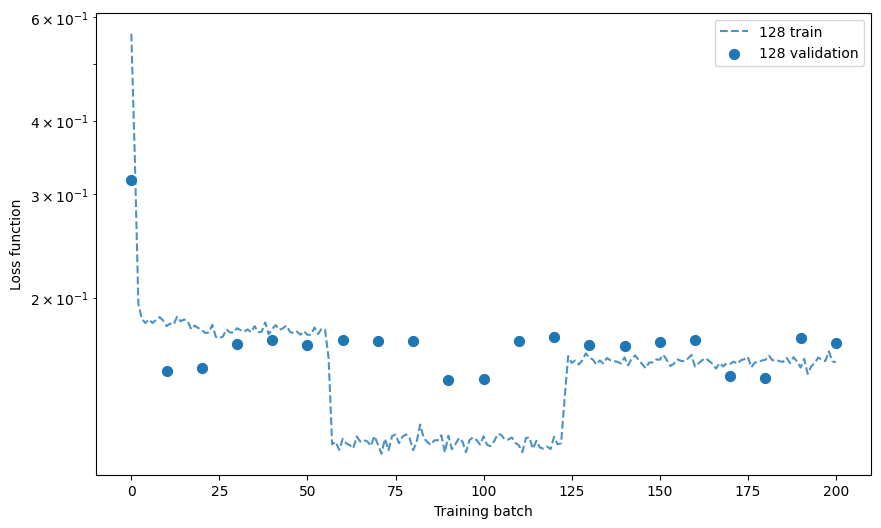

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    [x[0] for x in log[128]["train"]], 
    [x[1] for x in log[128]["train"]], 
    label="128 train",
    ls="--",
    alpha=0.8
)


ax.scatter(
    [x[0] for x in log[128]["val"]], 
    [x[1] for x in log[128]["val"]], 
    label="128 validation",
    color=mpl.cm.tab10(0),
    s=50
)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Loss function")
ax.set_xlabel("Training batch")

Text(0.5, 0, 'Training batch')

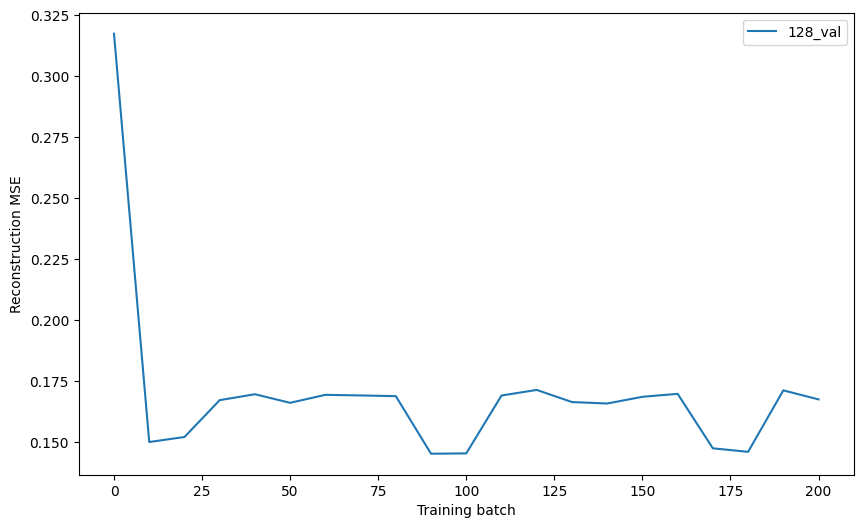

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([x[0] for x in log[128]["val_reconst"]], [x[1] for x in log[128]["val_reconst"]], label="128_val")

# ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Reconstruction MSE")
ax.set_xlabel("Training batch")

In [18]:
mean_nz_train = []
mean_nz_val = []
for step in range(training_steps):
    i = step % num_batches
    batch = jax.lax.dynamic_slice_in_dim(train_ds, i * batch_size, batch_size)
    mean_nz_train.append((step, (batch != 0).sum(axis=1).mean()))

    if step % eval_frequency == 0:
        num_val_batches = val_ds.shape[0] // batch_size
        i = step % num_val_batches
        val_batch = jax.lax.dynamic_slice_in_dim(val_ds, i * batch_size, batch_size)
        mean_nz_val.append((step, (val_batch != 0).sum(axis=1).mean()))

Text(0.5, 0, 'Training batch')

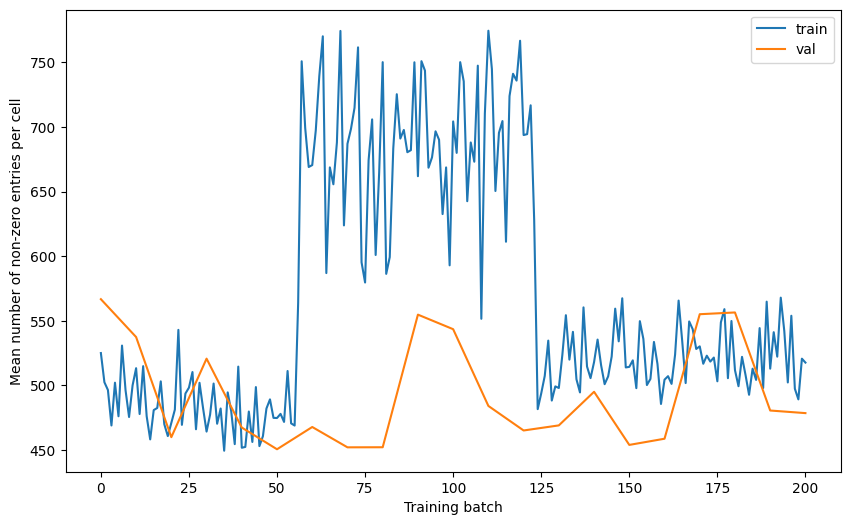

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([x[0] for x in mean_nz_train], [x[1] for x in mean_nz_train], label="train")
ax.plot([x[0] for x in mean_nz_val], [x[1] for x in mean_nz_val], label="val")

# ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Mean number of non-zero entries per cell")
ax.set_xlabel("Training batch")

Ok, we have better MSE performance when there is more data.

In [20]:
mean_nz_train = []
mean_nz_val = []
for step in range(training_steps):
    i = step % num_batches
    batch = jax.lax.dynamic_slice_in_dim(train_ds, i * batch_size, batch_size)
    mean_nz_train.append((step, batch.sum(axis=0).mean()))

    if step % eval_frequency == 0:
        num_val_batches = val_ds.shape[0] // batch_size
        i = step % num_val_batches
        val_batch = jax.lax.dynamic_slice_in_dim(val_ds, i * batch_size, batch_size)
        mean_nz_val.append((step, val_batch.sum(axis=0).mean()))

Text(0.5, 0, 'Training batch')

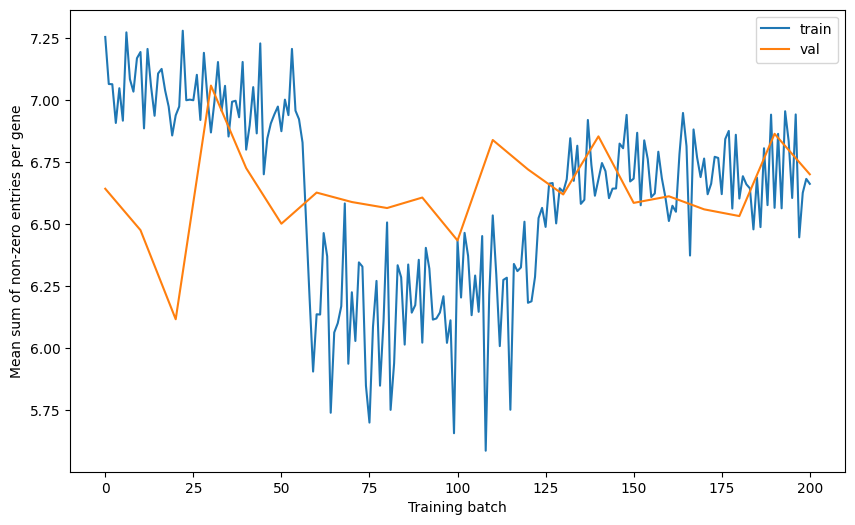

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([x[0] for x in mean_nz_train], [x[1] for x in mean_nz_train], label="train")
ax.plot([x[0] for x in mean_nz_val], [x[1] for x in mean_nz_val], label="val")

# ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Mean sum of non-zero entries per gene")
ax.set_xlabel("Training batch")

In [22]:
mean_nz_train = []
mean_nz_val = []
for step in range(training_steps):
    i = step % num_batches
    batch = jax.lax.dynamic_slice_in_dim(train_ds, i * batch_size, batch_size)
    mean_nz_train.append((step, batch[batch != 0].mean()))

    if step % eval_frequency == 0:
        num_val_batches = val_ds.shape[0] // batch_size
        i = step % num_val_batches
        val_batch = jax.lax.dynamic_slice_in_dim(val_ds, i * batch_size, batch_size)
        mean_nz_val.append((step, val_batch[val_batch != 0].mean()))

Text(0.5, 0, 'Training batch')

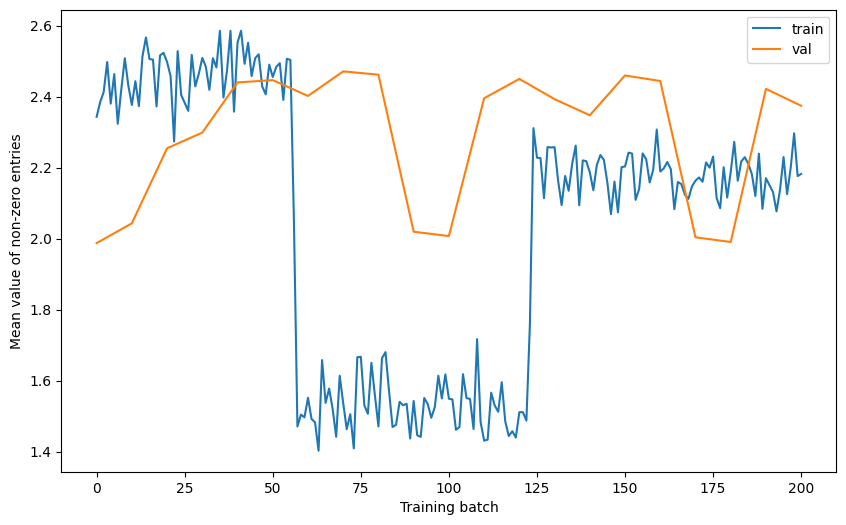

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([x[0] for x in mean_nz_train], [x[1] for x in mean_nz_train], label="train")
ax.plot([x[0] for x in mean_nz_val], [x[1] for x in mean_nz_val], label="val")

# ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Mean value of non-zero entries")
ax.set_xlabel("Training batch")

In [24]:
mean_nz_train = []
mean_nz_val = []
for step in range(training_steps):
    i = step % num_batches
    batch = jax.lax.dynamic_slice_in_dim(train_ds, i * batch_size, batch_size)
    mean_nz_train.append((step, jnp.mean(jnp.square(jnp.array(batch)))))

    if step % eval_frequency == 0:
        num_val_batches = val_ds.shape[0] // batch_size
        i = step % num_val_batches
        val_batch = jax.lax.dynamic_slice_in_dim(val_ds, i * batch_size, batch_size)
        mean_nz_val.append((step, jnp.mean(jnp.square(jnp.array(val_batch)))))

Text(0.5, 0, 'Training batch')

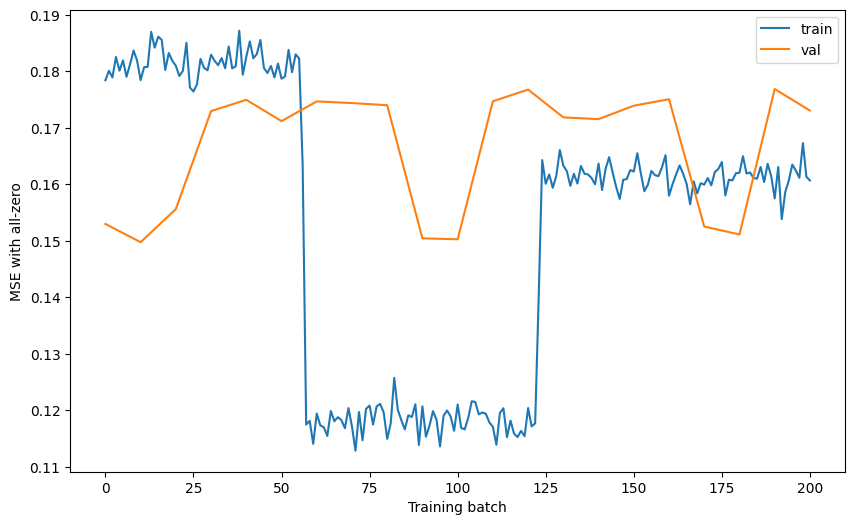

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([x[0] for x in mean_nz_train], [x[1] for x in mean_nz_train], label="train")
ax.plot([x[0] for x in mean_nz_val], [x[1] for x in mean_nz_val], label="val")

# ax.set_yscale("log")
ax.legend()
ax.set_ylabel("MSE with all-zero")
ax.set_xlabel("Training batch")

Text(0.5, 0, 'Training batch')

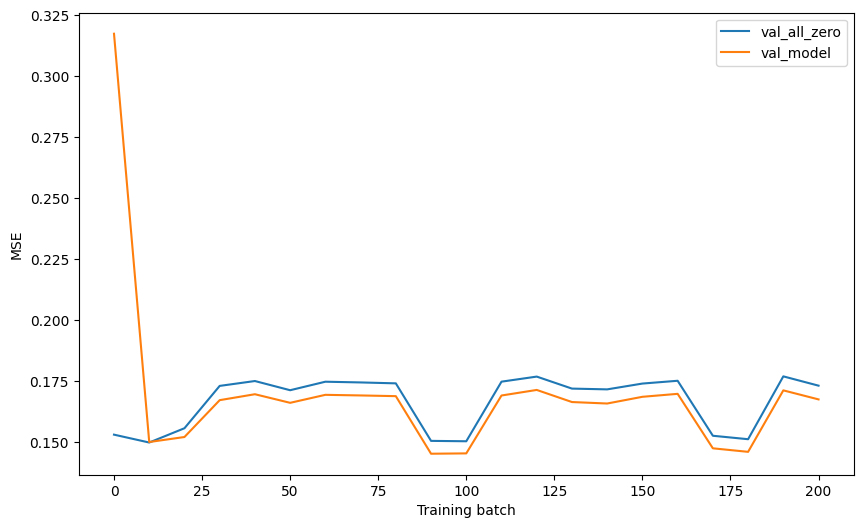

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([x[0] for x in mean_nz_val], [x[1] for x in mean_nz_val], label="val_all_zero")
ax.plot([x[0] for x in log[128]["val_reconst"]], [x[1] for x in log[128]["val_reconst"]], label="val_model")

# ax.set_ylim(0, 0.05)
ax.legend()
ax.set_ylabel("MSE")
ax.set_xlabel("Training batch")

Check metadata for these batches

In [26]:
meta = pd.read_csv("../data/metadata.csv", index_col=0)

In [27]:
meta.shape

(281528, 4)

In [28]:
c_data.shape

(105942, 21706)

In [29]:
cell_names = f["train_multi_inputs"]["axis1"].asstr()[:]

In [30]:
cell_names

array(['56390cf1b95e', 'fc0c60183c33', '9b4a87e22ad0', ...,
       '00783f28b463', 'e7abb1a0f251', '193992d571a5'], dtype=object)

In [31]:
meta = meta.loc[cell_names]

In [32]:
meta.iloc[:split_idx].shape

(95347, 4)

In [33]:
train_ds.shape

(95347, 21706)

In [34]:
train_meta = meta.iloc[:split_idx]

In [35]:
for step in range(training_steps):
    i = step % num_batches
    top_cell_t = train_meta.day.iloc[i * batch_size:(i + 1) * batch_size].value_counts()
    print(f"{step}\t{top_cell_t.index[0]}\t{top_cell_t.values[0] / batch_size:.2f}")

0	2	1.00
1	2	1.00
2	2	1.00
3	2	1.00
4	2	1.00
5	2	1.00
6	2	1.00
7	2	1.00
8	2	1.00
9	2	1.00
10	2	1.00
11	2	1.00
12	2	1.00
13	2	1.00
14	2	1.00
15	2	1.00
16	2	1.00
17	2	1.00
18	2	1.00
19	2	1.00
20	2	1.00
21	2	1.00
22	2	1.00
23	2	1.00
24	2	1.00
25	2	1.00
26	2	1.00
27	2	1.00
28	2	1.00
29	2	1.00
30	2	1.00
31	2	1.00
32	2	1.00
33	2	1.00
34	2	1.00
35	2	1.00
36	2	1.00
37	2	1.00
38	2	1.00
39	2	1.00
40	2	1.00
41	2	1.00
42	2	1.00
43	2	1.00
44	2	1.00
45	2	1.00
46	2	1.00
47	2	1.00
48	2	1.00
49	2	1.00
50	2	1.00
51	2	1.00
52	2	1.00
53	2	1.00
54	2	1.00
55	2	1.00
56	2	0.75
57	3	1.00
58	3	1.00
59	3	1.00
60	3	1.00
61	3	1.00
62	3	1.00
63	3	1.00
64	3	1.00
65	3	1.00
66	3	1.00
67	3	1.00
68	3	1.00
69	3	1.00
70	3	1.00
71	3	1.00
72	3	1.00
73	3	1.00
74	3	1.00
75	3	1.00
76	3	1.00
77	3	1.00
78	3	1.00
79	3	1.00
80	3	1.00
81	3	1.00
82	3	1.00
83	3	1.00
84	3	1.00
85	3	1.00
86	3	1.00
87	3	1.00
88	3	1.00
89	3	1.00
90	3	1.00
91	3	1.00
92	3	1.00
93	3	1.00
94	3	1.00
95	3	1.00
96	3	1.00
97	3	1.00
98	3	1.00
99	3	1.00
100	3	1.00

Aha, so the increased number of non-zero regions is because of batch effect for first donor for day 3 vs 2 and 4

**Conclusion**

Better performance is seen when there are more non-zero elements per cell. They also lower the mean non-zero value per batch.